In [48]:
# import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
#smalltest VB
# modeling
import xgboost as xg
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor

# model selection and hyper-parameters tuning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe   #Bayesian Search

# for scoring
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
file_path = 'dataset/AB_NYC_2019.csv'

data = pd.read_csv('dataset/AB_NYC_2019.csv')

data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Helper functions

In [26]:
def get_cartesian(lat=None,lon=None):
    '''
    Converts latitude and longitude arrays into (x,y,z) coordinates
    Input :
          latitude as array
          longitude as array
    Output :
          x,y,z cartesian coordinates
    '''
    # Change degrees to radians
    lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    R = 1 # radius of the earth = 6371 km but not needed as we will normalize

    # Convert to cartesian
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)

    return x,y,z

def preprocess(file_path,final_test_set=False):
  '''
  Fetches files in a given path and preprocess them to return a feature matrix X (dataframe) and target values y (dataframe)
  Input :
        files: path as string
        final_test_set: a boolean that is used only for the final test set
  Outputs : 
        X : Feature matrix as DataFrame
        y : Target values as DataFrame
  '''
  #Load file
  df = pd.read_csv('dataset/AB_NYC_2019.csv')

  # Remove entries with no price
  df = df[df['price']!=0]
  df = df[df['availability_365']!=0]

  # Replace NaN values by 0
  df['number_of_reviews'].fillna(0, inplace=True)
  df['reviews_per_month'].fillna(0, inplace=True)
  df['name'].fillna('Unnamed', inplace=True)
  df['last_review'].fillna('2099-01-01',inplace=True)

  # Processing dates
  df['last_review'] = pd.to_datetime(df['last_review'])
  df['day'] = df['last_review'].dt.day
  df['month'] = df['last_review'].dt.month
  df['year'] = df['last_review'].dt.year

  # Only keep columns of interest
  feature_columns = ['day','month','year','neighbourhood_group','room_type','price','minimum_nights','reviews_per_month','calculated_host_listings_count','availability_365','latitude','longitude']  
  categoricals = ['neighbourhood_group','room_type']
  df = df[feature_columns]

  #One hot encoding of categorical
  df = pd.get_dummies(df, columns=categoricals)

  #Transform latitude and longitude in cartesian coordinates (x,y,z) (Earth as a 3D sphere and (0,0,0) its center)
  zone = df[['latitude','longitude']].to_numpy()
  x,y,z = get_cartesian(zone[:,0],zone[:,1])
  df= df.drop(['latitude','longitude'], axis=1)
  df['x'] = x
  df['y'] = y
  df['z'] = z

  #Split the target variable from the features
  y_df = df['price']
  df= df.drop(['price'], axis=1)

  return df,y_df


def scores(y_true,y_pred, plot=False):
  '''
  Compute MAE, MSE, RMSE, R2 and MAPE scores and plot prediction errors
  Inputs :
        y_true : true target values
        y_pred : predictions
        plot: if True plots errors
  Outputs:
        A score dictionary containing the computed metrics
  '''
  #Compute MAE, MSE, RMSE, R2 and MAPE scores
  mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
  mse = mean_squared_error(y_true=y_true, y_pred=y_pred)
  rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
  r2 = r2_score(y_true=y_true, y_pred=y_pred)
  mape = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
  error_ratio_rmse = rmse/np.mean(y_true)
  error_ratio_mae = mae/np.mean(y_true)

  # Plot the obtained errors and residuals if plot argument is set to True
  if plot:
      fig, axs = plt.subplots(ncols=2,figsize=(15,5))
      x = np.arange(np.amin(y_true),np.amax(y_true))
      axs[0].scatter(y_pred,y_true,label="actual_vs_predicted")
      axs[0].plot(x,x,color='black',linestyle='dashed')
      axs[0].set_title("Actual vs. Predicted values")
      axs[0].set_ylabel("Actual")
      axs[0].set_xlabel("Predicted")
      axs[1].scatter(y_pred,y_true-y_pred,label="residual_vs_predicted")
      axs[1].plot(x,[0]*len(x),color='black',linestyle='dashed')
      axs[1].set_title("Residuals vs. Predicted Values")
      axs[1].set_ylabel("Residuals (Actuals-Predictions)")
      axs[1].set_xlabel("Predicted")
      fig.suptitle("Prediction errors")
      plt.show()

  # Print the scores
  print(f'R²: {r2}')
  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}')
  print(f'MAPE: {mape}')
  print(f'error_ratio_rmse: {error_ratio_rmse}')
  print(f'error_ratio_mae: {error_ratio_mae}')

  #Return the scores in a dictionary
  scores = {
            'R2': r2,
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'MAPE': mape,
            'error_ratio_rmse': error_ratio_rmse,
            'error_ratio_mae': error_ratio_mae,
            }

  return scores

# Preprocessing

In [27]:
X_df, y_df = preprocess(file_path)

## Split Train and Test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_df.to_numpy(), y_df.to_numpy(), test_size=0.20, random_state=100)

In [31]:
X_df.head()

,day,month,year,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,x,y,z
0,19,10,2018,1,0.21,6,365,0,1,0,0,0,0,1,0,0.209486,-0.729239,0.651403
1,21,5,2019,1,0.38,2,355,0,0,1,0,0,1,0,0,0.209008,-0.728119,0.652808
2,1,1,2099,3,0.00,1,365,0,0,1,0,0,0,1,0,0.209365,-0.727360,0.653540
3,5,7,2019,1,4.64,1,194,0,1,0,0,0,1,0,0,0.209529,-0.728781,0.651902
5,22,6,2019,3,0.59,1,129,0,0,1,0,0,1,0,0,0.209138,-0.728153,0.652729


# Decision Trees

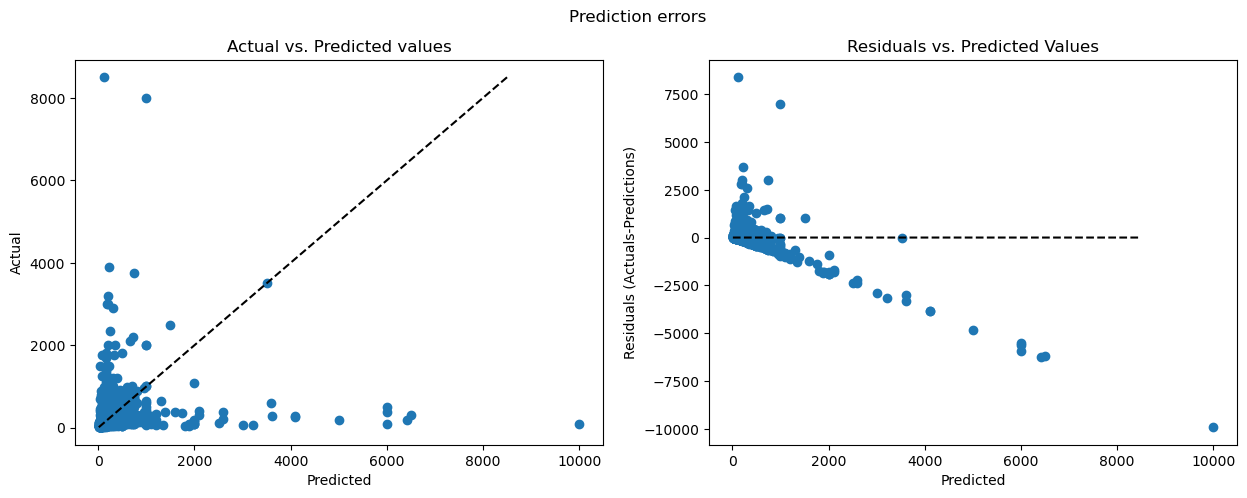

R²: -1.0667383510082091
MAE: 96.29134109392442
MSE: 120503.91851379366
RMSE: 347.1367432493911
MAPE: 0.6239416425463523
error_ratio_rmse: 2.162889805426793
error_ratio_mae: 0.5999582702004521


In [32]:
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
y_pred_dt_reg = dt_reg.predict(X_test)
dt_reg_scores = scores(y_test,y_pred_dt_reg,plot=True)

# Bagging

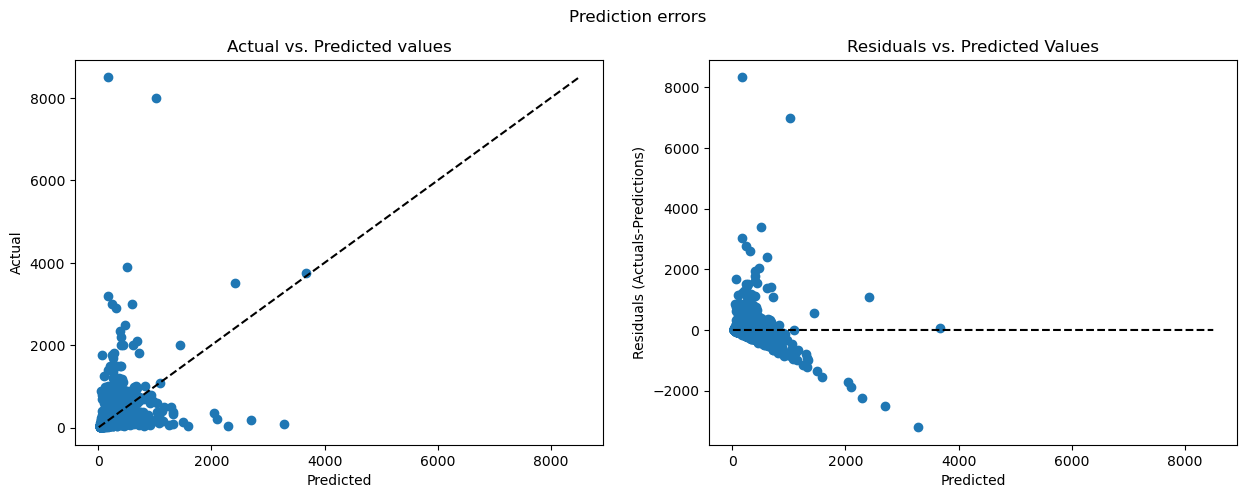

R²: 0.12176086604944936
MAE: 74.07574549513635
MSE: 51206.89659703396
RMSE: 226.2894089369495
MAPE: 0.49334795031358697
error_ratio_rmse: 1.4099315764858644
error_ratio_mae: 0.46154052509997767


In [53]:
bag = BaggingRegressor().fit(X_train, y_train)
y_pred_bag = bag.predict(X_test)
bag_scores=scores(y_test,y_pred_bag,plot=True)

# Random Forest

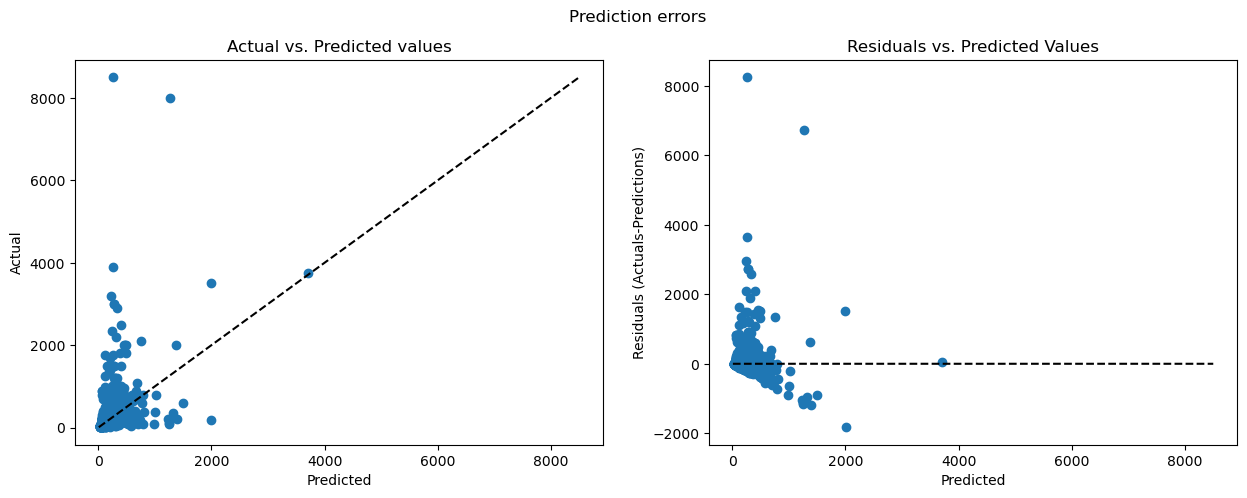

R²: 0.2385376080486611
MAE: 69.58220548580697
MSE: 44398.07389564334
RMSE: 210.70850456410946
MAPE: 0.45712840785496933
error_ratio_rmse: 1.3128523133923153
error_ratio_mae: 0.43354282083657864


In [33]:
rf = RandomForestRegressor(n_estimators = 300, max_features = 'sqrt', max_depth = 12, random_state = 18).fit(X_train, y_train)
y_pred_random_forest = rf.predict(X_test)
random_forest_scores=scores(y_test,y_pred_random_forest,plot=True)

# ADABOOST

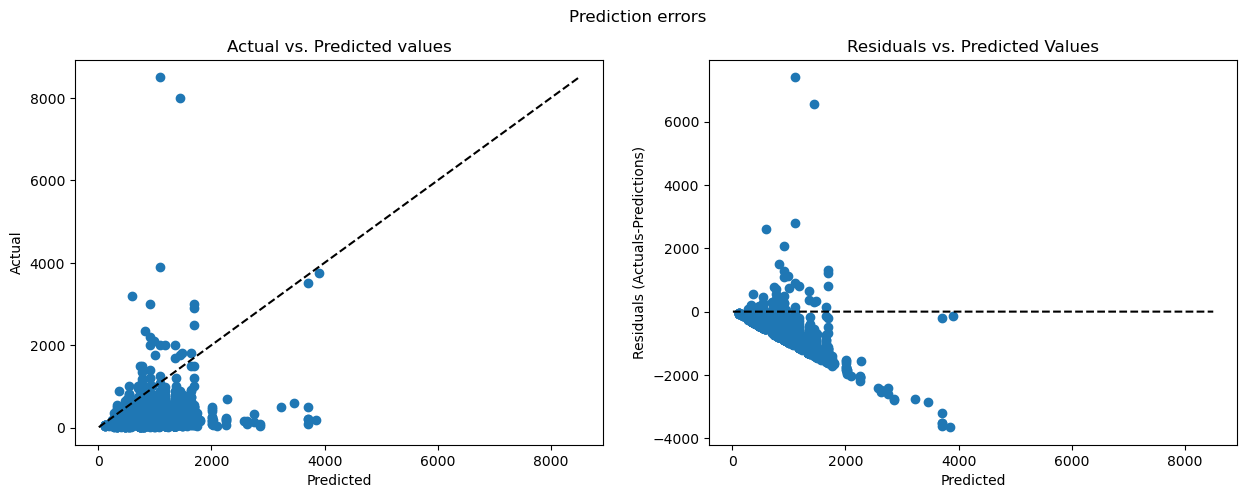

R²: -8.474803836262561
MAE: 645.4159632513687
MSE: 552440.9942178637
RMSE: 743.2637447217936
MAPE: 6.91815700863713
error_ratio_rmse: 4.631021081646706
error_ratio_mae: 4.021365166098843


In [45]:
ada = AdaBoostRegressor().fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
ada_scores=scores(y_test,y_pred_ada,plot= True)

# Gradient Boosting

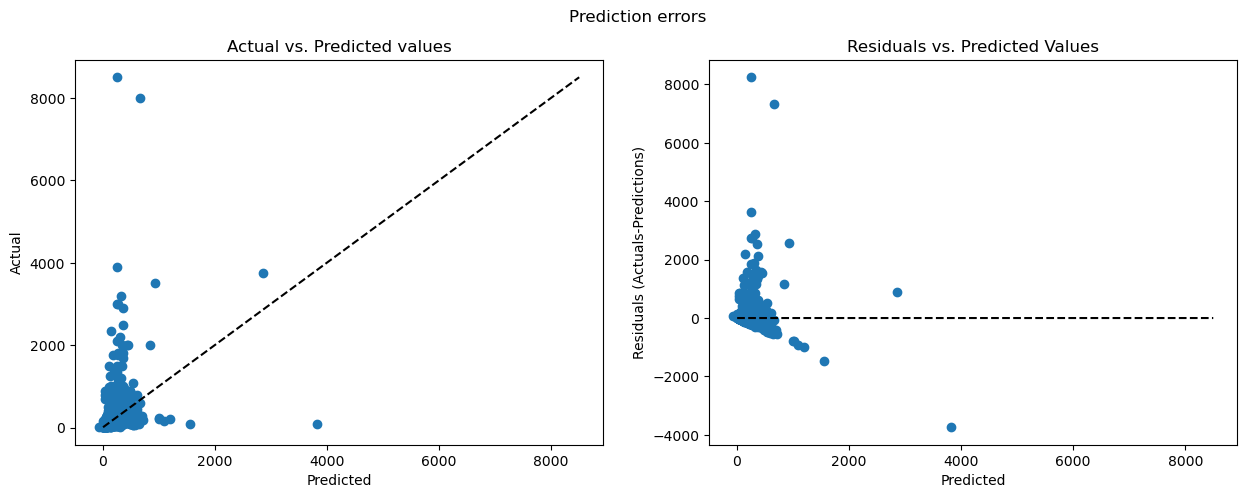

R²: 0.1575536286377297
MAE: 73.8188727347055
MSE: 49119.95213973601
RMSE: 221.63021486190914
MAPE: 0.49319806787393833
error_ratio_rmse: 1.3809017386413296
error_ratio_mae: 0.45994003916574


In [46]:
gbr = GradientBoostingRegressor().fit(X_train, y_train)
y_pred_gbr = gbr.predict(X_test)
gbr_scores=scores(y_test,y_pred_gbr,plot= True)

# Hist Gradient Boosting

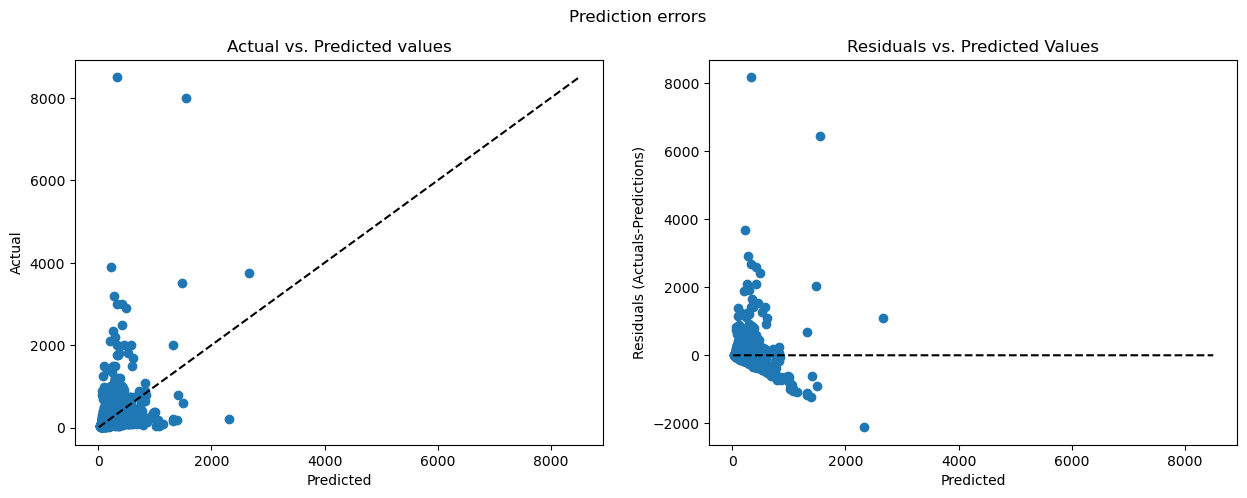

R²: 0.21677403492226732
MAE: 72.44457143763152
MSE: 45667.02786909266
RMSE: 213.6984507877693
MAPE: 0.4923808795765436
error_ratio_rmse: 1.331481641262924
error_ratio_mae: 0.4513772398573112


In [51]:
hgbr = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred_hgbr = hgbr.predict(X_test)
hgbr_scores=scores(y_test,y_pred_hgbr,plot= True)

# Light GBM

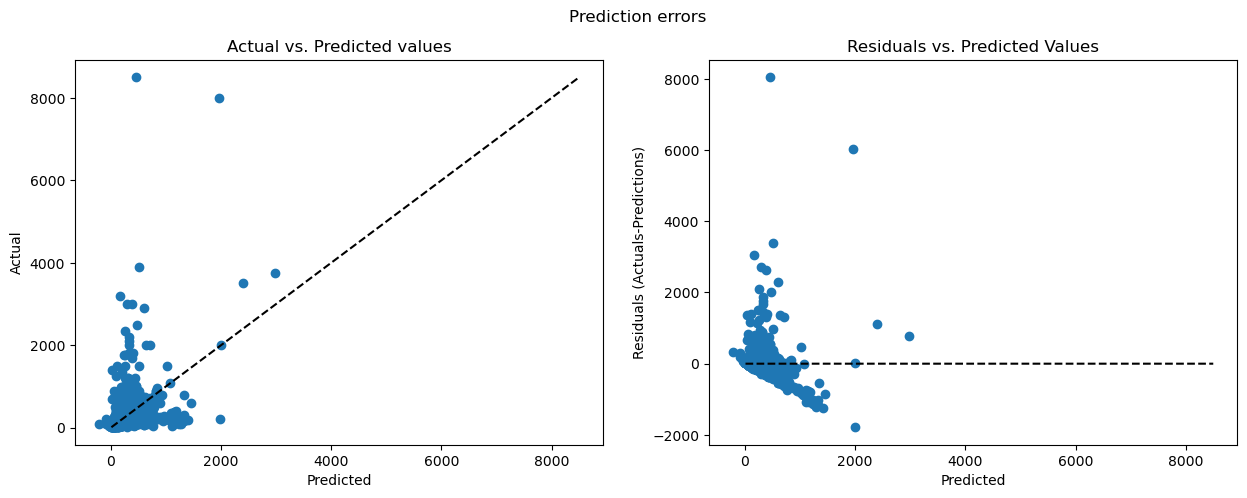

R²: 0.2517957829973567
MAE: 71.46396085873972
MSE: 43625.03843477823
RMSE: 208.86607775026138
MAPE: 0.4713912030778172
error_ratio_rmse: 1.3013727847903716
error_ratio_mae: 0.44526739218078626


In [49]:
lgbm = LGBMRegressor().fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)
lgbm_scores=scores(y_test,y_pred_lgbm,plot= True)

# XGBOOST

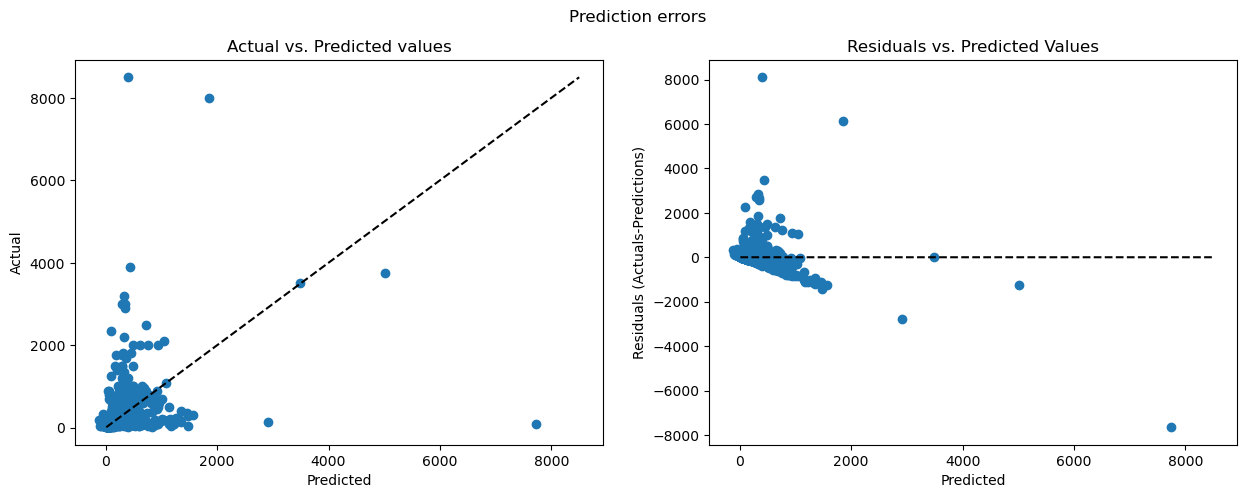

R²: 0.04429018155912645
MAE: 75.52186777784273
MSE: 55723.92752476392
RMSE: 236.05916106934703
MAPE: 0.5317538387334528
error_ratio_rmse: 1.4708035461048463
error_ratio_mae: 0.4705508162993137


In [50]:
xgb = xg.XGBRegressor().fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
xgb_scores=scores(y_test,y_pred_xgb,plot= True)

In [38]:
space={'max_depth': hp.quniform("max_depth", 3, 40, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,280,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,150),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 100, 400, 1),
        'seed': hp.quniform('seed', 0, 400, 1)
    }

In [56]:
def objective(space):
    mod=xg.XGBRegressor(
                          n_estimators =int(space['n_estimators']), 
                          max_depth = int(space['max_depth']), 
                          gamma = space['gamma'],
                          reg_alpha = space['reg_alpha'],
                          reg_lambda = space['reg_lambda'],
                          min_child_weight=int(space['min_child_weight']),
                          colsample_bytree=space['colsample_bytree'],
                          seed = int(space['seed'])
                       )
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    mod.set_params(eval_metric="rmse",early_stopping_rounds=10,)
    mod.fit(X_train, y_train,eval_set=evaluation,verbose=False)

    y_pred = mod.predict(X_test)
    score = scores(y_test,y_pred)['RMSE']
    print ("SCORE:", score)
    return {'loss': score, 'status': STATUS_OK }

In [57]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

R²: 0.24095609258037776                                
MAE: 65.9825802062273                                  
MSE: 44257.060949909464                                
RMSE: 210.37362227691347                               
MAPE: 0.4058249468191299                               
error_ratio_rmse: 1.3107657768931413                   
error_ratio_mae: 0.41111479219379654                   
SCORE:                                                 
210.37362227691347                                     
R²: 0.2453262863656689                                                           
MAE: 68.7519008577811                                                            
MSE: 44002.25100963071                                                           
RMSE: 209.7671351990838                                                          
MAPE: 0.44897210732519466                                                        
error_ratio_rmse: 1.3069869642400007                                             
erro

In [58]:
best_hyperparams

{'colsample_bytree': 0.5594099433168744,
 'gamma': 8.875982409058757,
 'max_depth': 10.0,
 'min_child_weight': 8.0,
 'n_estimators': 240.0,
 'reg_alpha': 203.0,
 'reg_lambda': 6.922776487986255,
 'seed': 210.0}

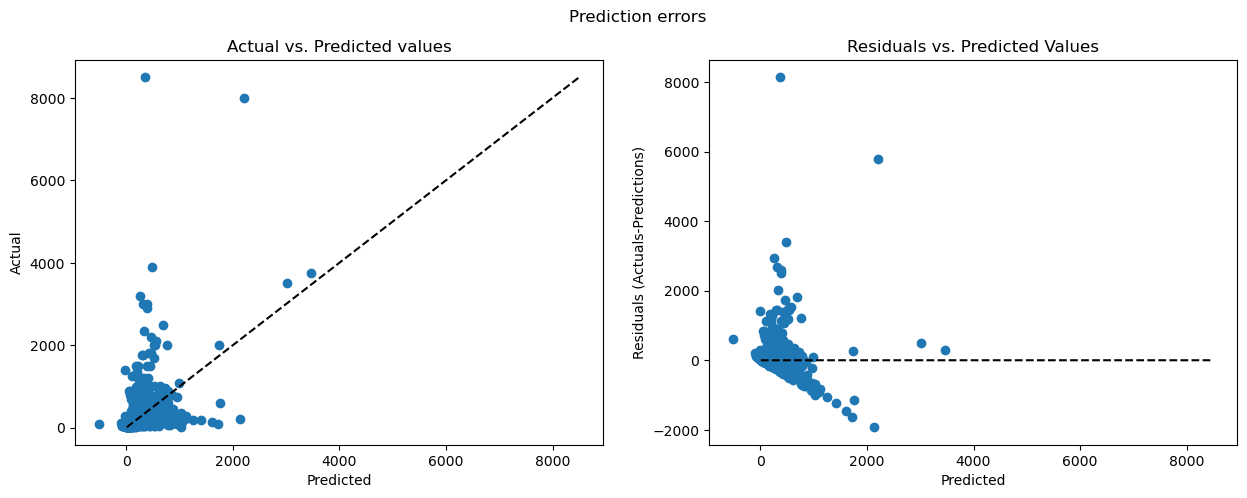

R²: 0.25190424372007225
MAE: 75.19955180404556
MSE: 43618.71448860203
RMSE: 208.85093844319215
MAPE: 0.5279753503529906
error_ratio_rmse: 1.3012784569683877
error_ratio_mae: 0.4685425761823887


In [44]:
xgb_tuned = xg.XGBRegressor(
                          n_estimators =int(best_hyperparams['n_estimators']), 
                          max_depth = int(best_hyperparams['max_depth']), 
                          gamma = best_hyperparams['gamma'],
                          reg_alpha = best_hyperparams['reg_alpha'],
                          reg_lambda = best_hyperparams['reg_lambda'],
                          min_child_weight=int(best_hyperparams['min_child_weight']),
                          colsample_bytree=best_hyperparams['colsample_bytree'],
                          seed = int(best_hyperparams['seed'])
                       )
evaluation = [( X_train, y_train), ( X_test, y_test)]

xgb_tuned.fit(X_train, y_train)#,eval_set=evaluation, eval_metric="rmse",early_stopping_rounds=10,verbose=False)

y_pred = xgb_tuned.predict(X_test)
score = scores(y_test,y_pred,plot=True)